In [1]:
import requests 
import gzip, shutil
import os 
import data_utils as du 
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
from six.moves import cPickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt 
import platform
%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Data_folder = 'CIFAR10_Data'
Data_fn = 'cifar-10-python'
cifar_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
#Chang to true if need download data 
Down_load_data = False 
if Down_load_data:
    r = requests.get(cifar_url,allow_redirects=True)
    open(os.path.join(Data_folder,Data_fn+'.tar.gz'),'wb').write(r.content)
    #Unzip the data


In [2]:
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
from six.moves import cPickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread
import platform

def load_pickle(f):
  version = platform.python_version_tuple()
  if version[0] == '2':
      return  pickle.load(f)
  elif version[0] == '3':
      return  pickle.load(f, encoding='latin1')
  raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(fn):
    with open(fn, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000,subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for training  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'CIFAR10_Data/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    ## Data post_process 
   
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(subtract_mean =True)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int64
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Load the pre-trained model 

In [4]:
from cnn_model import *
from solver import Solver
data_set = {
    'train_data': X_train,
    'train_label': y_train,
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'sgd',
    'lr': 0.01,
    'epoch_num': 20,
}

model_path = 'tmp/trained_20'
model = tf.keras.models.load_model(model_path,compile=False)
solver= Solver(model,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)


Loss: 1.2418395280838013,Test Accuracy: 61.76000213623047


## Question1: Plot weight and bias 

(122150,)


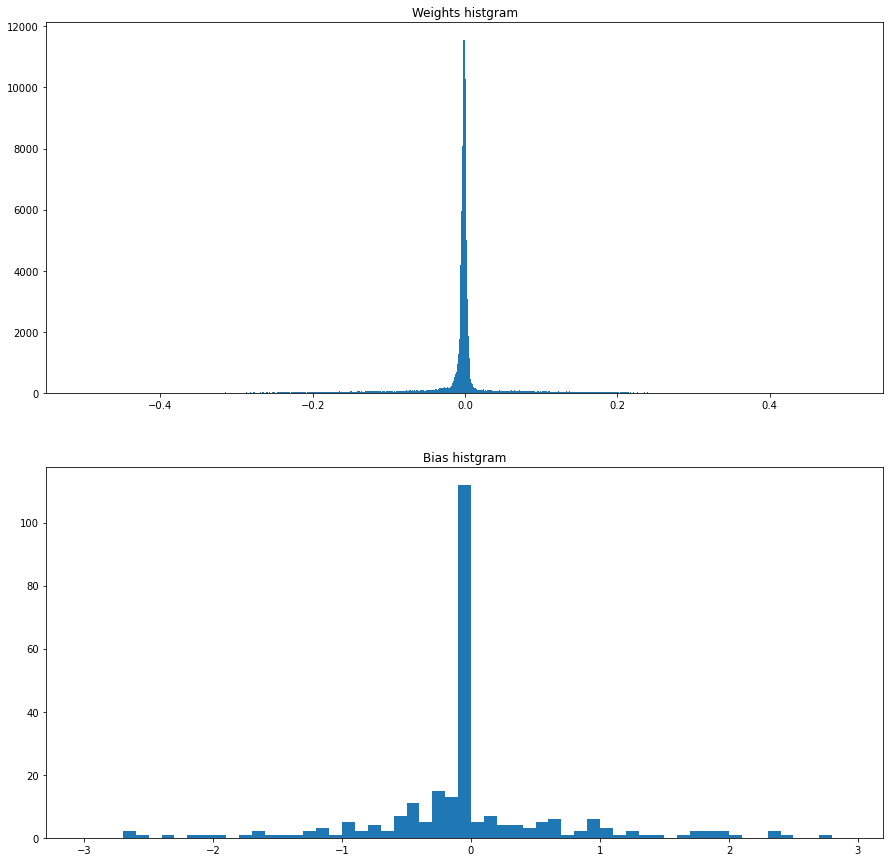

In [5]:
import matplotlib.pyplot as plt 
import re
weight_arr = np.empty((0,))
bias_arr = np.empty((0,))
for layer in model.layers:
    layer_name = layer.name
    #if layer_name == 'conv2d_6' or layer_name=='conv2d_7' or layer_name == 'dense_9' or layer_name == 'dens10' or layer_name=='dense_11':
    if re.search('conv',layer_name) or re.search('dense',layer_name):
        arr1 = layer.weights[0].numpy().reshape(-1)
        arr2 = layer.weights[1].numpy().reshape(-1)
        bias_arr = np.concatenate([bias_arr,arr2])
        weight_arr = np.concatenate([weight_arr, arr1])
print(weight_arr.shape)
weight_bins = [*np.arange(-0.5,0.5,.001)]
bias_bins = [*np.arange(-3,3,0.1)]
fig,axs = plt.subplots(2,1) 
#hist=np.histogram(weight_arr)
axs[0].hist(weight_arr,weight_bins)
axs[0].set_title('Weights histgram')
axs[1].hist(bias_arr,bias_bins)
axs[1].set_title('Bias histgram')
plt.show()


       

In [6]:
@tf.custom_gradient
def to_fixpoint(value,wl=8,fl=4):
    #max value 
    min_val = -2**(wl-fl-1)
    max_val = -min_val-2**(-fl)
    #print('max val:{},min_val:{}'.format(max_val,min_val))
    precision = 2**(-fl)
    value_q = tf.convert_to_tensor(value)
    value_q = tf.math.round(value_q/precision)*precision
    value_q = tf.clip_by_value(value_q,min_val,max_val)
    def grad(upstream):
        return upstream,0.0,0.0
    return value_q, grad 


to_fixpoint(np.array([1.2,1.2]),wl=8,fl=1).numpy()




array([1., 1.])

In [7]:
def quantize_abs_least_error(data,wl,fls):
    errors = [] 
    for fl in fls:
        quantized_data= to_fixpoint(data,wl,fl).numpy()
        error = np.min(np.abs(data-quantized_data))
        errors.append(error)
    return errors 

def quantize_abs_mean_error(data,wl,fls):
    errors = [] 
    for fl in fls:
        quantized_data= to_fixpoint(data,wl,fl).numpy()
        error = np.mean(np.abs(data-quantized_data))
        errors.append(error)
    return errors 


## Question2: Quantize the weight to 8bit

[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Text(0, 0.5, 'Error')

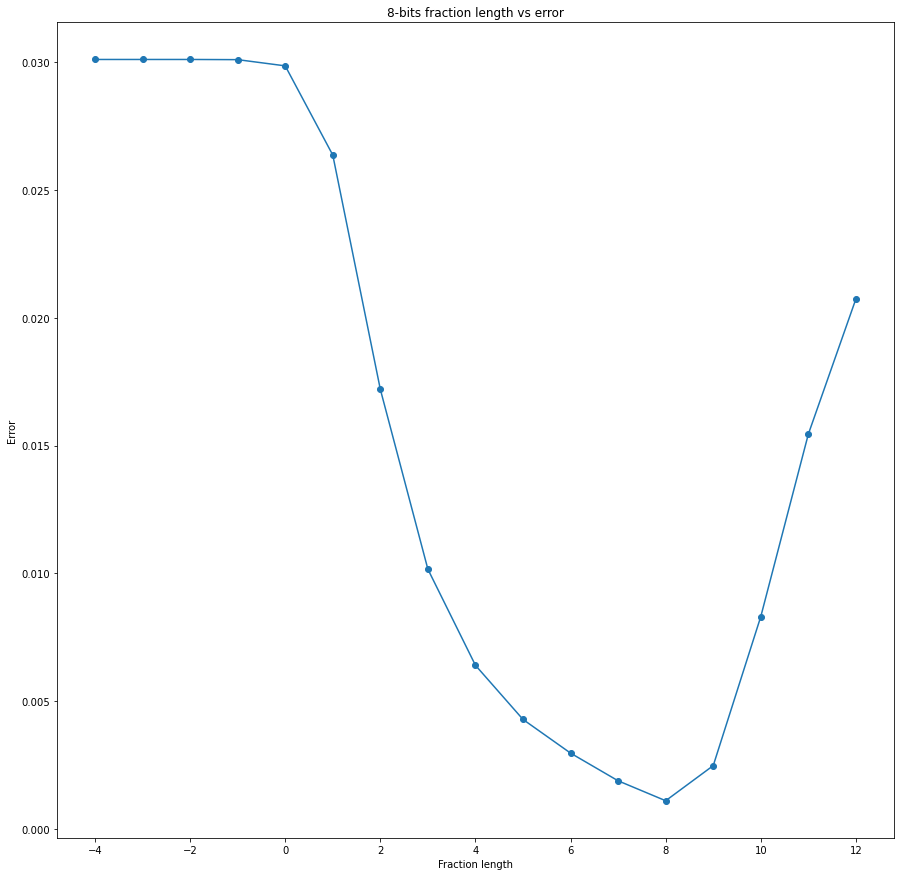

In [8]:
fl_optins = [*range(-4,13)]
print(fl_optins)
#quntized_weigth = to_fixpoint(weight_arr,wl=8,fl=4).numpy()
errors = quantize_abs_mean_error(weight_arr,8,fl_optins)
plt.plot(fl_optins,errors,'-o')
plt.title('8-bits fraction length vs error')
plt.xlabel('Fraction length')
plt.ylabel('Error')

## Question 3 Quantize bias wieght to 16-bits

Text(0, 0.5, 'Error')

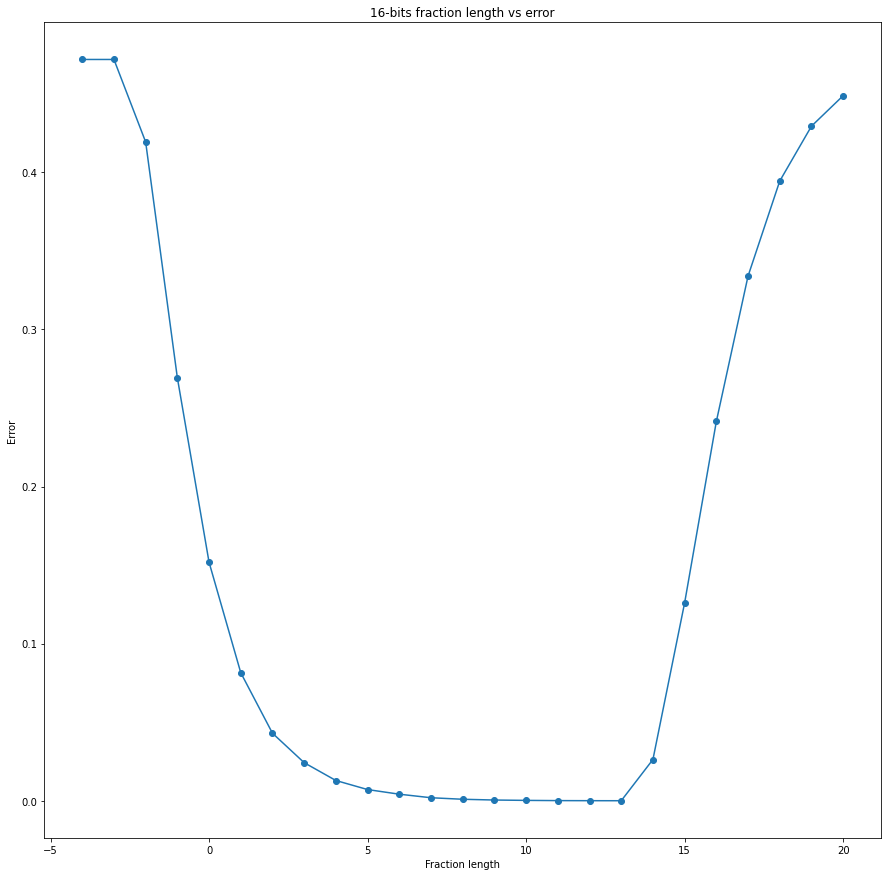

In [9]:

fl_optins = [*range(-4,21)]
errors = quantize_abs_mean_error(bias_arr,16,fl_optins)
plt.plot(fl_optins,errors,'-o')
plt.title('16-bits fraction length vs error')
plt.xlabel('Fraction length')
plt.ylabel('Error')


## Question 4 
Yes, the absolute mean error does represent how good is the fractional length and the error across all data points. Choose the fractional lenght produce the smalles error or fractional length near the smalles error. 


## Question 5 
Qunatize weight to 8-bits and bias to 16-bit 

weight: wl = 8, fl = 8 

bias : wl = 16, fl = 11 



In [10]:
import re 
def quantize_weights_bias(model,weight_wl=8,wieght_fl=8, bias_wl=16,bias_fl=8):
    for var in model.trainable_variables:
        if re.search('bias',var.name): 
            #print('find bias')
            var.assign(to_fixpoint(var, bias_wl,bias_fl))
        else:
            #print('find wieght')
            var.assign(to_fixpoint(var,weight_wl,wieght_fl))
def copy_weight(target_model,source_model,data):
    prediction = target_model(data,training=True)
    for i in range(len(target_model.trainable_variables)):
        target_model.trainable_variables[i].assign(source_model.trainable_variables[i])
    



In [11]:
import tensorflow_hub as hub
model_path = 'tmp/trained_20'
#model = tf.keras.models.load_model(model_path,compile=False) 
model = hub.KerasLayer(model_path,trainable=True)
solver= Solver(model,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)
model_q = Lennet5(in_channel=3, out_channel=10)


#Make the model trainable 
prediction = model_q(X_test,training= True) 
print('trainable length: {}'.format(len(model_q.trainable_variables)))
print('Trainable variable in model: ')
for var in model.trainable_variables:
    print(var.name)
print('\nTrainable variables in model_q:')
for var in model_q.trainable_variables:
    print(var.name)
for i in range(len(model_q.trainable_variables)):
    model_q.trainable_variables[i].assign(model.trainable_variables[i])

Loss: 1.2418395280838013,Test Accuracy: 61.76000213623047
trainable length: 10
Trainable variable in model: 
conv2d_6/kernel:0
conv2d_6/bias:0
conv2d_7/kernel:0
conv2d_7/bias:0
dense_9/kernel:0
dense_9/bias:0
dense_10/kernel:0
dense_10/bias:0
dense_11/kernel:0
dense_11/bias:0

Trainable variables in model_q:
lennet5/conv2d/kernel:0
lennet5/conv2d/bias:0
lennet5/conv2d_1/kernel:0
lennet5/conv2d_1/bias:0
lennet5/dense/kernel:0
lennet5/dense/bias:0
lennet5/dense_1/kernel:0
lennet5/dense_1/bias:0
lennet5/dense_2/kernel:0
lennet5/dense_2/bias:0


In [12]:
model_q = Lennet5(in_channel=3, out_channel=10)
copy_weight(model_q,model,X_test)
#Check the test accuracy of the model before weight and bias quantize 
solver= Solver(model_q,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)
# Quantize the model's weight and bias, check the test accuracy 
quantize_weights_bias(model_q)
solver= Solver(model_q,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)

Loss: 1.2418395280838013,Test Accuracy: 61.76000213623047
Loss: 1.2379509210586548,Test Accuracy: 61.63999938964844


## Question 6: 
Further quntize the input and intermediate feature map to 8-bit 


In [13]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
import tensorflow_hub as hub
from cnn_model import *
model_path = 'tmp/trained_20'
model = hub.KerasLayer(model_path,trainable=True)
solver= Solver(model,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)
model_q_options = {
    'quantize': True,
    'quantize_wl': 32,
    'quantize_fl': 16,
}
#Load the quantize model 
model_q = Quan_Lennet5(in_channel=3, out_channel=10,options=model_q_options)
copy_weight(model_q,model,X_test)
#quantize the wieght and bias 
quantize_weights_bias(model_q)
solver= Solver(model_q,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)


Loss: 1.2418395280838013,Test Accuracy: 61.76000213623047
Loss: 1.2379510402679443,Test Accuracy: 61.63999938964844


## Question 7 Finetune model 

Not able to recover the testing accuracy. The potential reson is the 8-bits size has low precision and low bound. Data reach the upper limit or lower limit during the traning, and lower precision aslo derease the accuracy. 


## Question8 Optimize the word length 


In [15]:
word_lengths = [*range(8,34,2)]
fraction_lengths = [*range(-4,21)]
model_path = 'tmp/trained_20'
full_model = hub.KerasLayer(model_path,trainable=True)
test_accs = [] 
opt_fls = [] 
for wl in word_lengths:
    wl_max_acc = 0.0 
    opt_fl = -100
    for fl in fraction_lengths:
        model_opt ={
            'quantize_wl': wl,
            'quantize_fl': fl,
        }
        model_q = Quan_Lennet5(3,10,options=model_opt)
        copy_weight(model_q,full_model,X_test[0:2])
        quantize_weights_bias(model_q)
        solver= Solver(model_q,data_set,options=train_options)
        print("wl:{} fl:{}".format(wl,fl))
        test_loss, test_acc = solver.test_model(X_test,y_test)
        if test_acc > wl_max_acc:
            wl_max_acc = test_acc 
            opt_fl = fl 
    test_accs.append(wl_max_acc)
    opt_fls.append(fl)


wl:8 fl:-4
Loss: 2.114511728286743,Test Accuracy: 21.65999984741211
wl:8 fl:-3
Loss: 1.847906231880188,Test Accuracy: 40.5099983215332
wl:8 fl:-2
Loss: 1.5076130628585815,Test Accuracy: 52.13999938964844
wl:8 fl:-1
Loss: 1.4121395349502563,Test Accuracy: 49.55999755859375
wl:8 fl:0
Loss: 1.7361738681793213,Test Accuracy: 34.959999084472656
wl:8 fl:1
Loss: 2.1869914531707764,Test Accuracy: 20.350000381469727
wl:8 fl:2
Loss: 2.500295400619507,Test Accuracy: 11.860000610351562
wl:8 fl:3
Loss: 2.6889686584472656,Test Accuracy: 10.019999504089355
wl:8 fl:4
Loss: 2.8619954586029053,Test Accuracy: 10.0
wl:8 fl:5
Loss: 3.023282766342163,Test Accuracy: 10.0
wl:8 fl:6
Loss: 3.0000147819519043,Test Accuracy: 10.0
wl:8 fl:7
Loss: 2.5727109909057617,Test Accuracy: 10.0
wl:8 fl:8
Loss: 2.40144681930542,Test Accuracy: 10.0
wl:8 fl:9
Loss: 2.3276422023773193,Test Accuracy: 10.0
wl:8 fl:10
Loss: 2.3093011379241943,Test Accuracy: 10.0
wl:8 fl:11
Loss: 2.304459810256958,Test Accuracy: 10.0
wl:8 fl:12
Los

KeyboardInterrupt: 

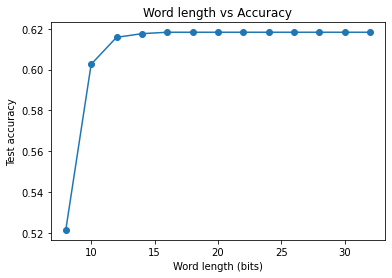

In [191]:
plt.plot(word_lengths,test_accs,'-o')
plt.xlabel('Word length (bits)')
plt.ylabel('Test accuracy')
plt.title('Word length vs Accuracy')
plt.show()

## Test the proper quantize Lennet5

In [18]:
import quantize_layers as ql 
import quantize_util as qu 
quantizer = ql.ModelQunatize()


model_option = {
    'conv_reg':0.02, 
}
model_qLennet = ql.proper_quantize_Lennet5(3,10,
                                options=model_option,
                                quantizer = quantizer)
model_qLennet.set_full_precision()



## Train the new quntized model 


## Compare qunatize model v1 and v2

In [21]:
for var in model_q.trainable_variables:
    print(var.name)
print("---------------------------")

prediction = model_qLennet(X_test,training= True) 
#qu.copy_weight(model_qLennet,model_q)
for var in model_qLennet.trainable_variables:
    print(var.name)

---------------------------
proper_quantize__lennet5_2/quantize_conv2d_4/kernel:0
proper_quantize__lennet5_2/quantize_conv2d_4/bias:0
proper_quantize__lennet5_2/quantize_conv2d_5/kernel:0
proper_quantize__lennet5_2/quantize_conv2d_5/bias:0
proper_quantize__lennet5_2/quantize_dense_6/kernel:0
proper_quantize__lennet5_2/quantize_dense_6/bias:0
proper_quantize__lennet5_2/quantize_dense_7/kernel:0
proper_quantize__lennet5_2/quantize_dense_7/bias:0
proper_quantize__lennet5_2/quantize_dense_8/kernel:0
proper_quantize__lennet5_2/quantize_dense_8/bias:0


In [87]:
solver= Solver(model_q,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)

Loss: 1.3024507761001587,Test Accuracy: 59.380001068115234


In [88]:

solver= Solver(model_qLennet,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)

Full precision layer: 0
Full precision layer: 1
Full precision layer: 2
Full precision layer: 3
Full precision layer: 4
Full precision layer: 5
Full precision layer: 6
Full precision layer: 7
Full precision layer: 8
Loss: 1.2379509210586548,Test Accuracy: 61.63999938964844


In [89]:
solver= Solver(model_qLennet,data_set,options=train_options)
model_qLennet.set_quantize()
test_loss, test_acc = solver.test_model(X_test,y_test)

Quantize layer: 0
Quantize layer: 1
Quantize layer: 2
Quantize layer: 3
Quantize layer: 4
Quantize layer: 5
Quantize layer: 6
Quantize layer: 7
Quantize layer: 8
Loss: 1.2379509210586548,Test Accuracy: 61.63999938964844


## Test on Full precison train (Work greate)

In [111]:
model_option = {
    'conv_reg':0.02, 
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 20,
}
model = ql.proper_quantize_Lennet5(3,10,
                                options=model_option,
                                quantizer = quantizer)
solver= Solver(model,data_set,options=train_options,save_model=False)
solver.train()
test_loss, test_acc = solver.test_model(X_test,y_test)

Epoch: 0/20
  308/1531 |=====********************|  - train_acc: 0.1931 - train_loss: 2.0833 - val_acc: 0.2890 - val_loss: 2.0724

KeyboardInterrupt: 

In [139]:
model_path = 'tmp/trained_20'
full_model = hub.KerasLayer(model_path,trainable=True)
model = ql.proper_quantize_Lennet5(3,10,
                                options=model_option,
                                quantizer = quantizer)
layer_count = model.get_quantiable_layer_count()
print("Total quantizable layer: {}".format(layer_count))
qu.copy_weight(model,full_model)
wlfl_list = [[16,8]]*layer_count
model.quantizer.set_wlfl_list(wlfl_list)
model.set_quantize() 
solver= Solver(model,data_set,options=train_options)
test_loss, test_acc = solver.test_model(X_test,y_test)



Total quantizable layer: 9
Loss: 1.6934784650802612,Test Accuracy: 37.22999954223633


In [141]:
model_path = 'tmp/trained_20'
full_model = hub.KerasLayer(model_path,trainable=True)
wl = 16 
fl = 8
model_opt ={
    'quantize_wl': wl,
    'quantize_fl': fl,
}

model_q = Quan_Lennet5(3,10,options=model_opt)
model_q.trainable() 
copy_weight(model_q,full_model,X_test[0:2])
#qu.copy_weight(model_q,full_model)
quantize_weights_bias(model_q)
solver= Solver(model_q,data_set,options=train_options)
print("wl:{} fl:{}".format(wl,fl))
test_loss, test_acc = solver.test_model(X_test,y_test)


TypeError: super(type, obj): obj must be an instance or subtype of type